### Jupyter Notebook to clean up the nytaxi2022.csv dataset

The purpose of this notebook is to do basic exploratory data analysis to check for missing/invalid data, remove outliers, perform encoding for categorical variables, prior to execution of Stochastic Gradient Descent using MPI.
The description of the attributes from [Kaggle](https://www.kaggle.com/datasets/diishasiing/revenue-for-cab-drivers/data) is as follows:

* VendorID: A unique identifier for the taxi vendor or service provider.
* tpep_pickup_datetime: The date and time when the passenger was picked up.
* tpep_dropoff_datetime: The date and time when the passenger was dropped off.
* passenger_count: The number of passengers in the taxi.
* trip_distance: The total distance of the trip in miles or kilometers.
* RatecodeID: The rate code assigned to the trip, representing fare types.
* store_and_fwd_flag: Indicates whether the trip data was stored locally and then forwarded later (Y/N).
* PULocationID: The unique identifier for the pickup location (zone or area).
* DOLocationID: The unique identifier for the drop-off location (zone or area).
* payment_type: The method of payment used by the passenger (e.g., cash, card).
* fare_amount: The base fare for the trip.
* extra: Additional charges applied during the trip (e.g., night surcharge).
* mta_tax: The tax imposed by the Metropolitan Transportation Authority.
* tip_amount: The tip given to the driver, if applicable.
* tolls_amount: The total amount of tolls charged during the trip.
* improvement_surcharge: A surcharge imposed for the improvement of services.
* total_amount: The total fare amount, including all charges and surcharges.
* congestion_surcharge: An additional charge for trips taken during high traffic congestion times.


Below we import the necessary libraries and define some of the constants of relevance

In [1]:
import numpy as np
import pandas as pd

# --------------------
# CONSTANTS
# --------------------
# Define expected input columns
EXPECTED_INPUT_COLUMNS = [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "passenger_count",
    "trip_distance",
    "RatecodeID",
    "PULocationID",
    "DOLocationID",
    "payment_type",
    "extra",
    "total_amount",
]

# Columns after one-hot encoding RatecodeID and payment_type
EXPECTED_RATECODE_COLUMNS = [f"RatecodeID_{i}" for i in [1, 2, 3, 4, 5, 6, 99]]
EXPECTED_PAYMENT_COLUMNS = [f"payment_type_{i}" for i in [1, 2, 3, 4, 5]]


# Columns associated with datetime features
EXPECTED_DATETIME_FEATURES = [
    f"tpep_pickup_datetime_{unit}" for unit in ["day", "month", "year", "hour", "minute", "second"]
] + [
    f"tpep_dropoff_datetime_{unit}" for unit in ["day", "month", "year", "hour", "minute", "second"]
]

# Complete list of features (excluding label)
EXPECTED_FEATURE_COLUMNS = (
    ["passenger_count", "trip_distance", "extra", "PULocationID", "DOLocationID"] 
    + EXPECTED_RATECODE_COLUMNS
    + EXPECTED_PAYMENT_COLUMNS
    + EXPECTED_DATETIME_FEATURES
    + ["trip_duration"]
)

To avoid having to read the Python file multiple times, storing the pickled file for faster reads and processing in subsequent runs

In [2]:
import pandas as pd
import os

csv_file = "../../data/nytaxi2022.csv"
pkl_file = "../../data/nytaxi2022.pkl"

if os.path.exists(pkl_file):
    # Fast path: load from pickle
    df = pd.read_pickle(pkl_file)
else:
    # Slow path: read CSV, then cache as pickle
    df = pd.read_csv(
        csv_file,
        header=0,
        parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"]
    )
    df.to_pickle(pkl_file)

### Exploratory Data Analysis

In [3]:
# Before any exploration, limit the dataframe to only the expected input columns
df = df[EXPECTED_INPUT_COLUMNS].copy()

In [4]:
# Find the number of missing values in each column
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values/len(df) * 100)  # Print as percentage

Missing values in each column:
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          3.450423
trip_distance            0.000000
RatecodeID               3.450423
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
extra                    0.000000
total_amount             0.000000
dtype: float64


Since the percentage of missing values isn't significantly high, it is alright to drop the corresponding rows rather than imputing values.

In [5]:
df.dropna(inplace=True)

In [6]:
# get a desctriptive statistics summary of the dataframe
df.describe(include='all')

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,extra,total_amount
count,38287795,38287795,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07
mean,2022-07-05 00:02:30.606806528,2022-07-05 00:57:11.752203264,1.401149e+00,3.514399e+00,1.424172e+00,1.649293e+02,1.628563e+02,1.232061e+00,1.040985e+00,2.142373e+01
min,2001-01-01 00:03:14,2001-01-01 00:34:17,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-2.218000e+01,-2.567800e+03
25%,2022-04-07 19:04:36.500000,2022-04-07 19:21:25,1.000000e+00,1.100000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,0.000000e+00,1.230000e+01
50%,2022-06-30 23:33:04,2022-06-30 23:50:20,1.000000e+00,1.860000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,5.000000e-01,1.595000e+01
75%,2022-10-04 17:04:52.500000,2022-10-04 17:23:22,1.000000e+00,3.490000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.500000e+00,2.277000e+01
max,2023-04-18 14:30:05,2023-04-18 23:30:39,9.000000e+00,1.843408e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,3.350000e+01,4.010956e+05
std,NaN,NaN,9.628938e-01,5.643246e+01,5.794343e+00,6.494462e+01,7.015708e+01,4.760829e-01,1.271069e+00,9.801355e+01


In [7]:
# check for duplicate rows so they don't skew the model training
duplicate_rows = df.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

Number of duplicate rows: 1


Since there is only 1 duplicate row, we can drop it without much concern

In [8]:
df.drop_duplicates(inplace=True)

The descriptive statistics along with the Kaggle description gives a good idea of the distribution of the numerical attributes at hand.
We will perform the following in subsequent steps:
- Modify the datetime objects to get the individual features (day, month, year, hour, minute, second) and defining the trip duration attribute, dropping the original datetime attributes 
- Describe the trip duration attribute to potentially filter out any negative or extremely large values
- Look for outliers for extra and total_amount as well
- Identify unique values for the categorical columns (RatecodeID, PULocationID, DOLocationID, payment_type) to determine the encoding that may be suitable for them 

In [9]:
def get_datetime_features(df, col_name):
    '''
    Derive datetime features from a datetime column
    '''
    dt = df[col_name].dt
    features = pd.DataFrame({
        col_name + "_day": dt.day,
        col_name + "_month": dt.month,
        col_name + "_year": dt.year,
        col_name + "_hour": dt.hour,
        col_name + "_minute": dt.minute,
        col_name + "_second": dt.second,
    }, index=df.index)
    return pd.concat([df, features], axis=1)

# Derive datetime features
df = get_datetime_features(df, "tpep_pickup_datetime")
df = get_datetime_features(df, "tpep_dropoff_datetime")

# Trip duration in minutes
df["trip_duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60

# Drop original datetime columns
df.drop(columns=["tpep_pickup_datetime", "tpep_dropoff_datetime"], inplace=True)

In [10]:
# Describe the trip duration to identify any negative or extremely large values
df["trip_duration"].describe()

count    3.828779e+07
mean     5.468576e+01
std      1.966705e+04
min     -7.175993e+04
25%      7.350000e+00
50%      1.213333e+01
75%      1.966667e+01
max      1.032206e+07
Name: trip_duration, dtype: float64

In [11]:
# Drop trips with negative or zero duration, limit to trips less than 180 minutes (3 hours)
df = df[(df["trip_duration"] > 0) & (df["trip_duration"] <= 180)]

In [12]:
# Look for outliers in extra and total_amount
df[['extra', 'total_amount']].describe()

,extra,total_amount
count,3.822030e+07,3.822030e+07
mean,1.041380e+00,2.141236e+01
std,1.271175e+00,9.806654e+01
min,-2.218000e+01,-2.567800e+03
25%,0.000000e+00,1.230000e+01
50%,5.000000e-01,1.595000e+01
75%,2.500000e+00,2.277000e+01
max,3.350000e+01,4.010956e+05


Going by the description of attributes from Kaggle, both the attributes cannot have negative values, with extra being non-negative and total_amount being positive. Also, the max value of total_amount is extremely high compared to the mean, we can try looking at some confidence intervals to see the rows we want to retain

In [13]:
# Filter out rows with negative extra and zero/negative total_amount
df = df[(df["extra"] >= 0) & (df["total_amount"] > 0)]

# Identify 99% confidence interval for total_amount to filter out extreme outliers
lower_bound = df["total_amount"].quantile(0.005)
upper_bound = df["total_amount"].quantile(0.995)
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
print(f"Percentage of outliers: {len(df[(df['total_amount'] < lower_bound) | (df['total_amount'] > upper_bound)])/len(df) * 100}")

Lower bound: 5.8, Upper bound: 93.96
Percentage of outliers: 0.9394557120998955


As the percentage of outliers looks admissible, we will proceed to drop the corresponding rows.

In [14]:
df = df[(df['total_amount'] >= lower_bound) & (df['total_amount'] <= upper_bound)]

In [15]:
# Gather the frequency counts of categorical variables
categorical_columns = ["RatecodeID", "payment_type", "PULocationID", "DOLocationID"]
for col in categorical_columns:
    print(f"Value counts for {col}:")
    print(df[col].value_counts(normalize=True) * 100)  # Print as percentage
    print()

Value counts for RatecodeID:
RatecodeID
1.0     94.978401
2.0      3.857667
5.0      0.601269
99.0     0.350761
3.0      0.128166
4.0      0.083433
6.0      0.000303
Name: proportion, dtype: float64

Value counts for payment_type:
payment_type
1    79.372954
2    20.062210
3     0.320594
4     0.244240
5     0.000003
Name: proportion, dtype: float64

Value counts for PULocationID:
PULocationID
237    4.814447
132    4.767549
236    4.258112
161    4.057440
186    3.361516
         ...   
109    0.000035
199    0.000032
204    0.000024
84     0.000016
99     0.000011
Name: proportion, Length: 262, dtype: float64

Value counts for DOLocationID:
DOLocationID
236    4.362336
237    4.164382
161    3.710522
170    2.998097
230    2.987994
         ...   
2      0.000096
204    0.000074
105    0.000056
99     0.000045
110    0.000003
Name: proportion, Length: 262, dtype: float64



### Encoding categorical features

Since the RatecodeID and payment_type have few dominant categories, we will proceed with one-hot encoding them. The PULocationID and DOLocationID have a large number of unique values, so we will perform frequency encoding on them.    

In [16]:
    # Since there are 6 unique values for RatecodeID, 263 for PULocationID, 262 for DOLocationID and 5 for payment_type
    # taking into account the volume of data, using one hot encoding for ratecodeId and payment_type,
    # using frequency encoding for PULocationID and DOLocationID
    df["RatecodeID"] = df["RatecodeID"].astype("Int64")
    df["RatecodeID"] = pd.Categorical(df["RatecodeID"], categories=[1, 2, 3, 4, 5, 6, 99])

    df["payment_type"] = df["payment_type"].astype("Int64")
    df["payment_type"] = pd.Categorical(df["payment_type"], categories=[1, 2, 3, 4, 5])

    df = pd.get_dummies(df, columns=["RatecodeID", "payment_type"], prefix=["RatecodeID", "payment_type"])

    for col in ["PULocationID", "DOLocationID"]:
        freq = df[col].value_counts(normalize=True)
        df[col] = df[col].map(freq).fillna(0)

### Final round of checks before publishing the processed file

Below we do some final checks before writing the data post processing data to a file to use in the main Python code for NeuralNet implementation of SGD using MPI

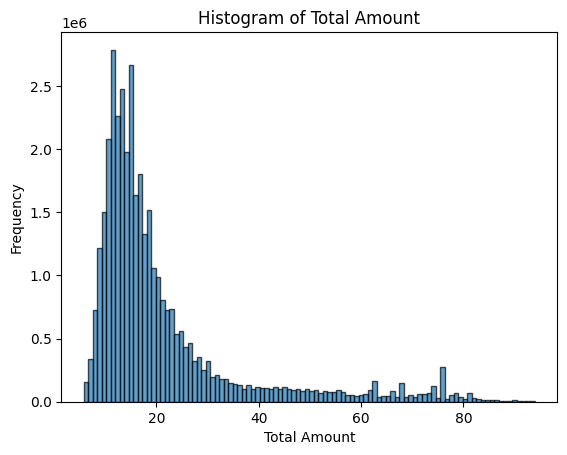

In [24]:
# Plot histogram of total_amount
import matplotlib.pyplot as plt
plt.hist(df["total_amount"], bins=100, edgecolor='k', alpha=0.7)
plt.title("Histogram of Total Amount")
plt.xlabel("Total Amount")
plt.ylabel("Frequency")
plt.show()

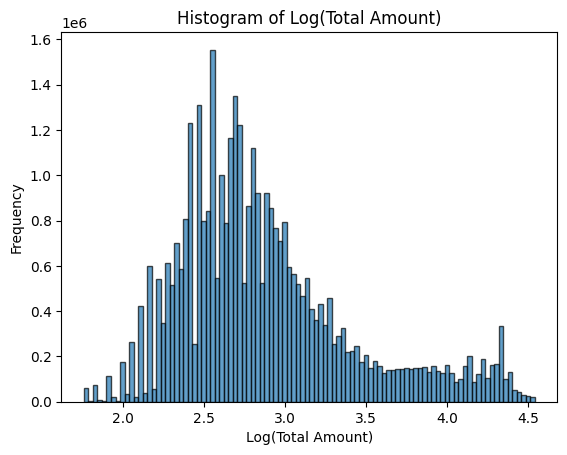

In [26]:
# Plot histogram of log(total_amount)
import matplotlib.pyplot as plt
plt.hist(np.log(df["total_amount"]), bins=100, edgecolor='k', alpha=0.7)
plt.title("Histogram of Log(Total Amount)")
plt.xlabel("Log(Total Amount)")
plt.ylabel("Frequency")
plt.show()

In [27]:
def final_checks(df):
    # Tracking feature_columns and skip_normalization_columns to skip normalization of the attributes
    # that are the derived date-time attributes, were one-hot encoded or frequency encoded above
    # these features are for exploring the variation of rmse with and without normalization
    # of categorical features for a neural net using SGD
    skip_normalization_columns = [
        col for col in df.columns
        if col.startswith("RatecodeID_")
        or col.startswith("payment_type_")
        or col.startswith("tpep_pickup_datetime_")
        or col.startswith("tpep_dropoff_datetime_")
        or col in ["PULocationID", "DOLocationID"]
    ]
    
    feature_columns = [c for c in df.columns if c != "total_amount"]

    # ensuring X and y are of type float64 as object type arrays cause errors with MPI Allreduce
    X = df[feature_columns].values.astype(np.float64) 
    y = np.log(df["total_amount"]).values.astype(np.float64)

    # stack X and y back into a dataframe to return a single dataframe
    df = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))), columns=feature_columns + ["total_amount"])
    return df, feature_columns, skip_normalization_columns

df, feature_columns, skip_normalization_columns = final_checks(df)

In [28]:
df.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,extra,tpep_pickup_datetime_day,tpep_pickup_datetime_month,tpep_pickup_datetime_year,tpep_pickup_datetime_hour,tpep_pickup_datetime_minute,...,RatecodeID_4,RatecodeID_5,RatecodeID_6,RatecodeID_99,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,total_amount
count,3.760366e+07,3.760366e+07,3.760366e+07,3.760366e+07,3.760366e+07,3.760366e+07,3.760366e+07,3.760366e+07,3.760366e+07,3.760366e+07,...,3.760366e+07,3.760366e+07,3.760366e+07,3.760366e+07,3.760366e+07,3.760366e+07,3.760366e+07,3.760366e+07,3.760366e+07,3.760366e+07
mean,1.400886e+00,3.449259e+00,2.572680e-02,2.014759e-02,1.057177e+00,1.561934e+01,6.602548e+00,2.022000e+03,1.421867e+01,2.953681e+01,...,8.343337e-04,6.012686e-03,3.031620e-06,3.507611e-03,7.937295e-01,2.006221e-01,3.205938e-03,2.442395e-03,2.659316e-08,2.880214e+00
std,9.632015e-01,5.374978e+01,1.238989e-02,1.147161e-02,1.269129e+00,8.750457e+00,3.374099e+00,5.610413e-02,5.737698e+00,1.732159e+01,...,2.887278e-02,7.730805e-02,1.741152e-03,5.912113e-02,4.046269e-01,4.004658e-01,5.653017e-02,4.936021e-02,1.630741e-04,5.417442e-01
min,0.000000e+00,0.000000e+00,1.063726e-07,2.659316e-08,0.000000e+00,1.000000e+00,1.000000e+00,2.001000e+03,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.757858e+00
25%,1.000000e+00,1.100000e+00,1.660628e-02,1.195596e-02,0.000000e+00,8.000000e+00,4.000000e+00,2.022000e+03,1.100000e+01,1.400000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.509599e+00
50%,1.000000e+00,1.870000e+00,2.644139e-02,2.112946e-02,5.000000e-01,1.500000e+01,6.000000e+00,2.022000e+03,1.500000e+01,3.000000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.770086e+00
75%,1.000000e+00,3.470000e+00,3.329522e-02,2.743901e-02,2.500000e+00,2.300000e+01,1.000000e+01,2.022000e+03,1.900000e+01,4.500000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.116178e+00
max,9.000000e+00,1.843408e+05,4.814447e-02,4.362336e-02,3.350000e+01,3.100000e+01,1.200000e+01,2.023000e+03,2.300000e+01,5.900000e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.542869e+00


In [29]:
df.shape

(37603658, 31)

In [30]:
df.isna().sum() * 100 / len(df) > 0

passenger_count                 False
trip_distance                   False
PULocationID                    False
DOLocationID                    False
extra                           False
tpep_pickup_datetime_day        False
tpep_pickup_datetime_month      False
tpep_pickup_datetime_year       False
tpep_pickup_datetime_hour       False
tpep_pickup_datetime_minute     False
tpep_pickup_datetime_second     False
tpep_dropoff_datetime_day       False
tpep_dropoff_datetime_month     False
tpep_dropoff_datetime_year      False
tpep_dropoff_datetime_hour      False
tpep_dropoff_datetime_minute    False
tpep_dropoff_datetime_second    False
trip_duration                   False
RatecodeID_1                    False
RatecodeID_2                    False
RatecodeID_3                    False
RatecodeID_4                    False
RatecodeID_5                    False
RatecodeID_6                    False
RatecodeID_99                   False
payment_type_1                  False
payment_type

In [31]:
# printing the feature columns and skip normalization columns for sanity check
# and for also copying over to use in the normalization step in the main logic of the project
print(feature_columns)
print(skip_normalization_columns)

['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'extra', 'tpep_pickup_datetime_day', 'tpep_pickup_datetime_month', 'tpep_pickup_datetime_year', 'tpep_pickup_datetime_hour', 'tpep_pickup_datetime_minute', 'tpep_pickup_datetime_second', 'tpep_dropoff_datetime_day', 'tpep_dropoff_datetime_month', 'tpep_dropoff_datetime_year', 'tpep_dropoff_datetime_hour', 'tpep_dropoff_datetime_minute', 'tpep_dropoff_datetime_second', 'trip_duration', 'RatecodeID_1', 'RatecodeID_2', 'RatecodeID_3', 'RatecodeID_4', 'RatecodeID_5', 'RatecodeID_6', 'RatecodeID_99', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4', 'payment_type_5']
['PULocationID', 'DOLocationID', 'tpep_pickup_datetime_day', 'tpep_pickup_datetime_month', 'tpep_pickup_datetime_year', 'tpep_pickup_datetime_hour', 'tpep_pickup_datetime_minute', 'tpep_pickup_datetime_second', 'tpep_dropoff_datetime_day', 'tpep_dropoff_datetime_month', 'tpep_dropoff_datetime_year', 'tpep_dropoff_datetime_hour', 'tpep_dro

In [32]:
assert not df.isna().any().any(), "NaNs remain in dataframe after preprocessing!"

### Publishing the processed file

In [33]:
pd.DataFrame.to_csv(df, "../../data/processed/nytaxi2022_preprocessed_final.csv", index=False)

In [34]:
df1 = pd.read_csv("../../data/processed/nytaxi2022_preprocessed_final.csv")
df1.shape

(37603658, 31)

In [1]:
import pandas as pd
import os

csv_file = "../../data/nytaxi2022.csv"
pkl_file = "../../data/nytaxi2022.pkl"

if os.path.exists(pkl_file):
    # Fast path: load from pickle
    df = pd.read_pickle(pkl_file)
else:
    # Slow path: read CSV, then cache as pickle
    df = pd.read_csv(
        csv_file,
        header=0,
        parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"]
    )
    df.to_pickle(pkl_file)
df.shape

(39656098, 19)